## Import Package and Data

In [53]:
# Loading neccesary packages:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p
from sklearn.preprocessing import PowerTransformer

#

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

#

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

## Data Exploration

In [3]:
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (1460, 81)
test shape: (1459, 80)


In [4]:
print(f"train columns: {train.columns}")
print(f"test columns: {test.columns}")

train columns: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCon

In [5]:
# Dropping Unneeded Columns
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [6]:
# Identify Target
y = train['SalePrice'].reset_index(drop=True)
y.shape

(1460,)

In [7]:
# Saving Train/Test Features
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

### Correlation Table

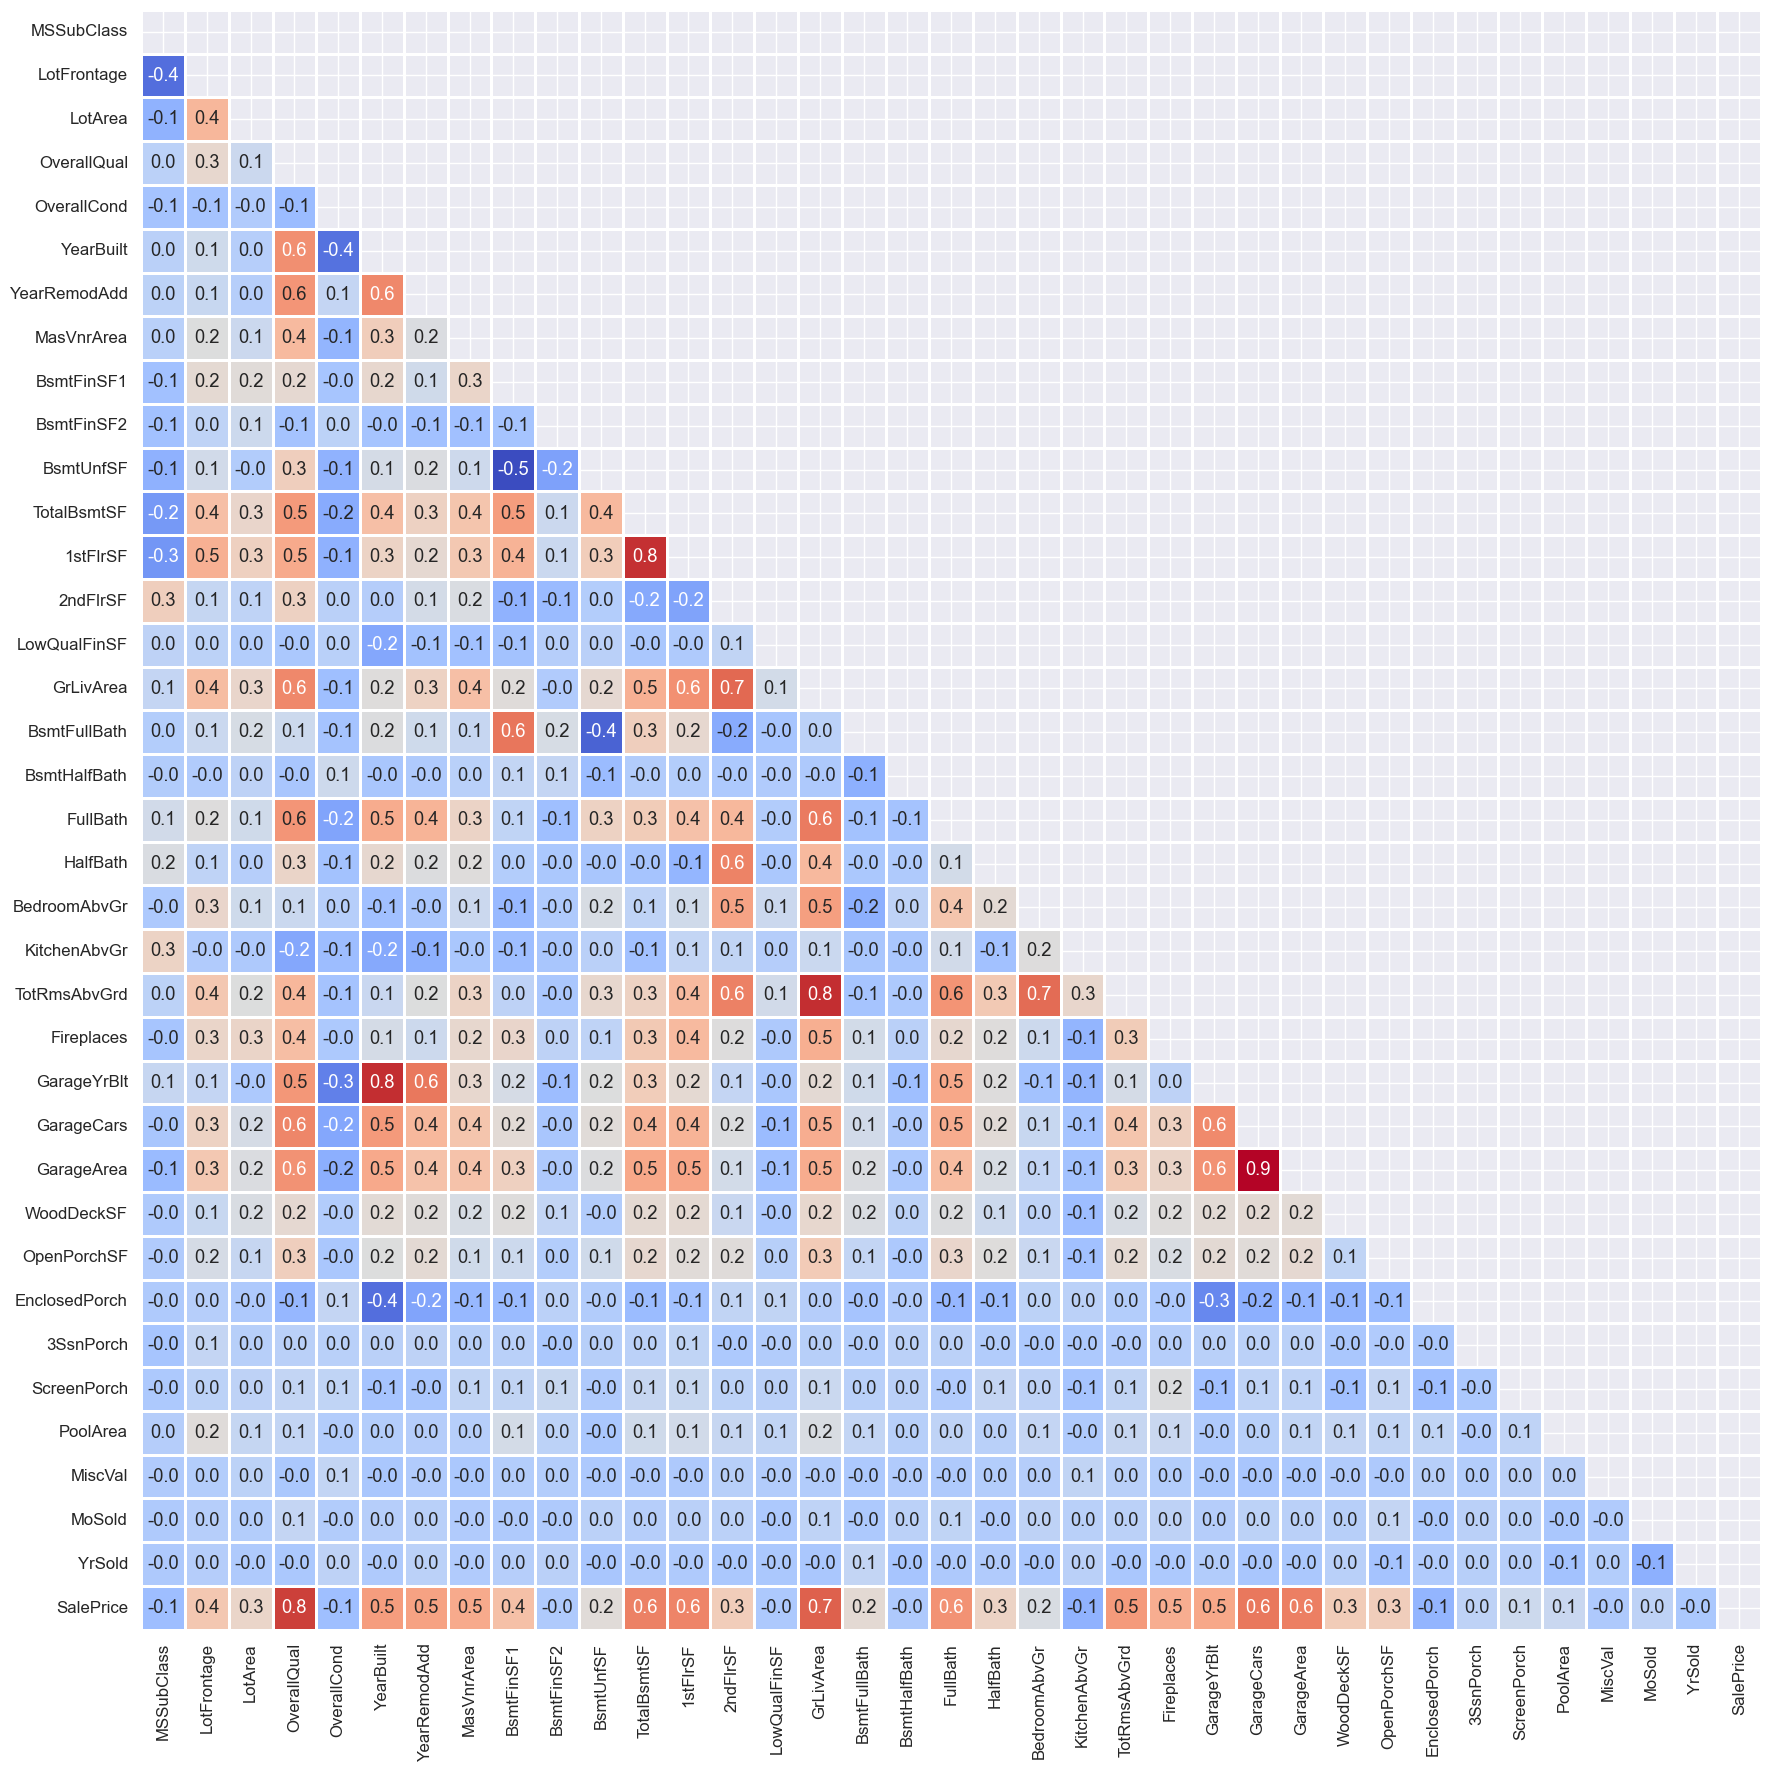

In [8]:
# Display numerical correlations (pearson) between features on heatmap.

sns.set_theme(font_scale=1.1)
correlation_train = train.corr(numeric_only=True)
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

Observations:
- Strong correlation with target (>0.5):
    - Quality indicators of house
        - overall Quality
        - year built
        - year remodeled
        - garage year built
    - Square footage of the house
        - above ground living area
        - basement area
        - 1st floor area, 2nd floor area
        - number of rooms above ground
        - garage area
    - Amenities of the house
        - number of bathrooms
        - fireplace
        - garage space (# of cars can store)
- Questions raised:
    - Overall condition has a slight negative corr, why?

In [9]:
# Merge Train/Test to do engineering on both
features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

(2919, 79)

### Missing Data

In [10]:
def missing_percentage(df):
    
    """A function for returning missing ratios."""
    
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

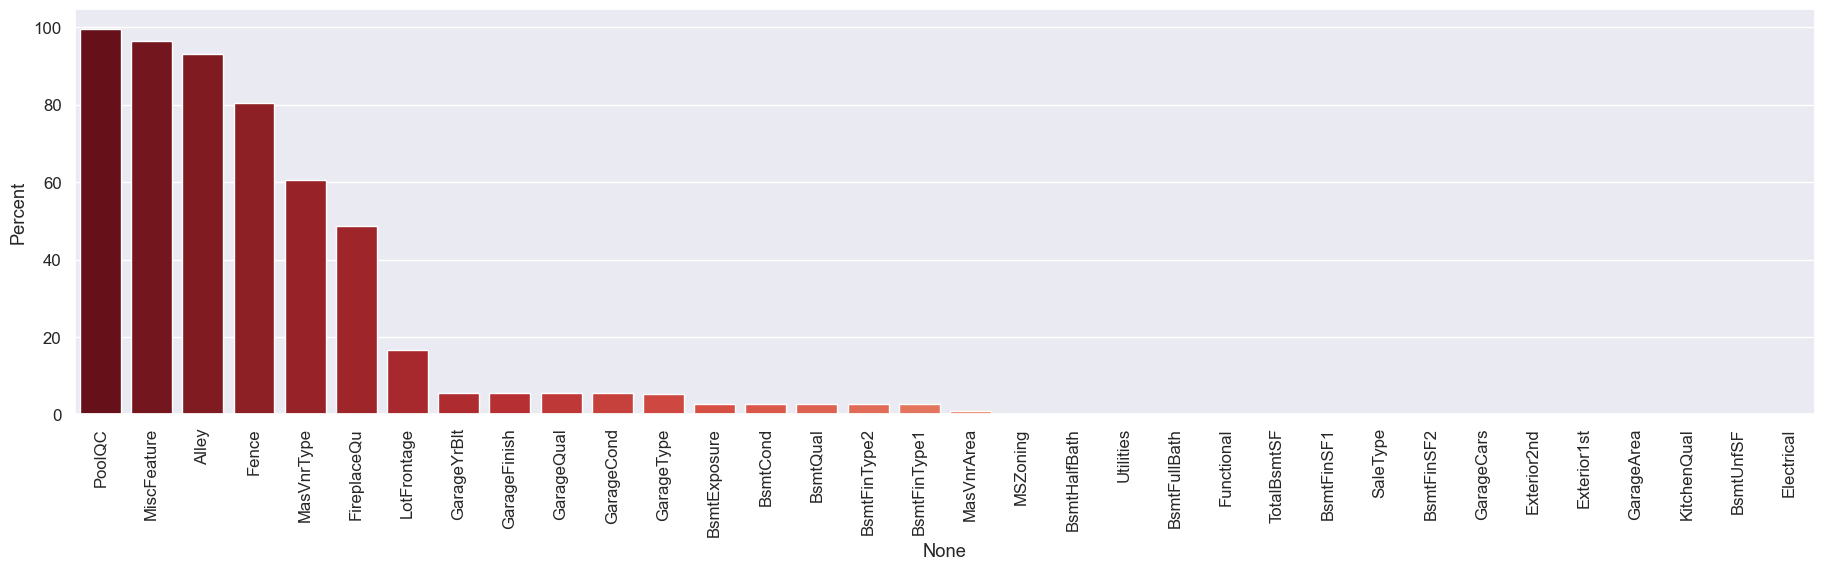

In [11]:
# Checking 'NaN' values.

missing = missing_percentage(features)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

Observations:
- Fill missing with `None` or 0 if "meaningful missingness"
- Fill with Most Frequent or mean if "missing completely at random"

In [12]:
# List of 'NaN' including columns where NaN's mean none.

none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

# List of 'NaN' including columns where NaN's mean 0.

zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

# List of 'NaN' including columns where NaN's actually missing gonna replaced with mode.

freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]

# Filling the list of columns above with appropriate values:

for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)

In [13]:
# Fill missing in zoning using MSsubclass
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Fill front yard space with Neighborhood median value
features['LotFrontage'] = features.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# convert some numerical valued features to ordinal, i.e., year, month.
features['MSSubClass'] = features['MSSubClass'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

## Feature Engineering

In [14]:
# check if any missing values remain
assert features.isnull().sum().values.sum() == 0

In [15]:
# Reduce the number of category labels by converting any label that appears < 10 times as "Other"
others = [
    'Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType'
]

for col in others:
    mask = features[col].isin(
        features[col].value_counts()[features[col].value_counts() < 10].index)
    features[col][mask] = 'Other'

In [16]:
# Visualize Categorical Data

def srt_box(y, df):
    
    '''A function for displaying categorical variables.'''
    
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

### Categorical Data Inspection

#### MSZoning

In [17]:
print(f"Unique labels of: {train_features['MSZoning'].value_counts()}")

grouped = y.groupby(train_features['MSZoning'])
stats = grouped.describe()
median = grouped.median()
mode = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
stats['median'] = median
stats['mode'] = mode
column_order = ['count', 'mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']
stats = stats[column_order]
stats = stats.sort_values(by='mean', ascending=False)

stats

Unique labels of: MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64


count           mean    median    mode           std       min  \
MSZoning                                                                    
FV          65.0  214014.061538  205950.0  151000  52369.662067  144152.0   
RL        1151.0  191004.994787  174000.0  135000  80766.341319   39300.0   
RH          16.0  131558.375000  136500.0  145000  35714.118435   76000.0   
RM         218.0  126316.830275  120500.0  115000  48521.689833   37900.0   
C (all)     10.0   74528.000000   74700.0   34900  33791.092031   34900.0   

                25%       50%       75%       max  
MSZoning                                           
FV        174000.00  205950.0  250000.0  370878.0  
RL        137700.00  174000.0  224700.0  755000.0  
RH        106150.00  136500.0  148608.5  200000.0  
RM        100000.00  120500.0  140000.0  475000.0  
C (all)    43998.25   74700.0   98332.0  133900.0

- MSZoning
    - `FV`: Floating village houses. Some kind of special area that retired community resides, has the highest median value.
    - `RL`: Residental low density houses comes second with the some outliers.
    - `RH`, `RM`, `C`: Residental high and medium seems similar meanwhile commercial is the lowest.

#### LandContour

In [18]:
print(f"Unique labels of: {train_features['LandContour'].value_counts()}")

grouped = y.groupby(train_features['LandContour'])
stats = grouped.describe()
median = grouped.median()
mode = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
stats['median'] = median
stats['mode'] = mode
column_order = ['count', 'mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']
stats = stats[column_order]
stats = stats.sort_values(by='mean', ascending=False)

stats

Unique labels of: LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64


count           mean    median    mode            std      min  \
LandContour                                                                    
HLS            50.0  231533.940000  222250.0  135000  101790.139741  82500.0   
Low            36.0  203661.111111  190000.0  260000   83935.353620  39300.0   
Lvl          1311.0  180183.746758  162900.0  140000   78463.567918  34900.0   
Bnk            63.0  143104.079365  139400.0  110000   49361.244074  52500.0   

                  25%       50%        75%       max  
LandContour                                           
HLS          151750.0  222250.0  281347.25  538000.0  
Low          143000.0  190000.0  263750.00  385000.0  
Lvl          130000.0  162900.0  212000.00  755000.0  
Bnk          113000.0  139400.0  171250.00  315000.0

- LandContour
    - `HLS`: hillside houses has higher prices
    - `BnK`: Bank side has the lowest prices

#### Neighborhood

In [19]:
print(f"Unique labels of: {train_features['Neighborhood'].value_counts()}")

grouped = y.groupby(train_features['Neighborhood'])
stats = grouped.describe()
median = grouped.median()
mode = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
stats['median'] = median
stats['mode'] = mode
column_order = ['count', 'mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']
stats = stats[column_order]
stats = stats.sort_values(by='mean', ascending=False)

stats

Unique labels of: Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64


count           mean    median    mode            std       min  \
Neighborhood                                                                    
NoRidge        41.0  335295.317073  301500.0  290000  121412.658640  190000.0   
NridgHt        77.0  316270.623377  315000.0  202500   96392.544954  154000.0   
StoneBr        25.0  310499.000000  278000.0  170000  112969.676640  170000.0   
Timber         38.0  242247.447368  228475.0  175000   64845.651549  137500.0   
Veenker        11.0  238772.727273  218000.0  162500   72369.317959  162500.0   
Somerst        86.0  225379.837209  225500.0  151000   56177.555888  144152.0   
ClearCr        28.0  212565.428571  200250.0  190000   50231.538993  130000.0   
Crawfor        51.0  210624.725490  200624.0  145000   68866.395472   90350.0   
CollgCr       150.0  197965.773333  197200.0  230000   51403.666438  110000.0   
Blmngtn        17.0  194870.882353  191000.0  159895   30393.229219  159895.0   
Gilbert        79.0  192854.506329  181000.0  174000   35986.779085  141000.0   
NWAmes         73.0  189050.068493  182900.0  190000   37172.218106   82500.0   
SawyerW        59.0  186555.796610  179900.0  144000   55651.997820   76000.0   
Mitchel        49.0  156270.122449  153500.0  129500   36486.625334   84500.0   
NAmes         225.0  145847.080000  140000.0  140000   33075.345450   87500.0   
NPkVill         9.0  142694.444444  146000.0  148500    9377.314529  127500.0   
SWISU          25.0  142591.360000  139500.0  140000   32622.917679   60000.0   
Blueste         2.0  137500.000000  137500.0  124000   19091.883092  124000.0   
Sawyer         74.0  136793.135135  135000.0  125000   22345.129157   62383.0   
OldTown       113.0  128225.300885  119000.0   87000   52650.583185   37900.0   
Edwards       100.0  128219.700000  121750.0  108000   43208.616459   58500.0   
BrkSide        58.0  124834.051724  124300.0  100000   40348.689270   39300.0   
BrDale         16.0  104493.750000  106000.0  106000   14330.176493   83000.0   
IDOTRR         37.0  100123.783784  103000.0   55000   33376.710117   34900.0   
MeadowV        17.0   98576.470588   88000.0   75000   23491.049610   75000.0   

                    25%       50%        75%       max  
Neighborhood                                            
NoRidge       265000.00  301500.0  341000.00  755000.0  
NridgHt       253293.00  315000.0  374000.00  611657.0  
StoneBr       213500.00  278000.0  377426.00  556581.0  
Timber        186900.00  228475.0  286115.75  378500.0  
Veenker       184250.00  218000.0  282000.00  385000.0  
Somerst       177975.00  225500.0  252919.50  423000.0  
ClearCr       183750.00  200250.0  242225.00  328000.0  
Crawfor       159250.00  200624.0  239000.00  392500.0  
CollgCr       152958.75  197200.0  225725.00  424870.0  
Blmngtn       174000.00  191000.0  213490.00  264561.0  
Gilbert       174000.00  181000.0  197200.00  377500.0  
NWAmes        165150.00  182900.0  205000.00  299800.0  
SawyerW       145500.00  179900.0  222500.00  320000.0  
Mitchel       131000.00  153500.0  171000.00  271000.0  
NAmes         127500.00  140000.0  158000.00  345000.0  
NPkVill       140000.00  146000.0  148500.00  155000.0  
SWISU         128000.00  139500.0  160000.00  200000.0  
Blueste       130750.00  137500.0  144250.00  151000.0  
Sawyer        127250.00  135000.0  149462.50  190000.0  
OldTown       105900.00  119000.0  140000.00  475000.0  
Edwards       101500.00  121750.0  145225.00  320000.0  
BrkSide       100500.00  124300.0  141175.00  223500.0  
BrDale         91000.00  106000.0  118000.00  125000.0  
IDOTRR         81000.00  103000.0  120500.00  169500.0  
MeadowV        83500.00   88000.0  115000.00  151400.0

- Neighborhood
    - `NoRidge`, `NridgHt`, `StoneBr`, `Timber`, `Veenker`: top 5 most expensive communities
    - other analysis factors:
        - highest standard devitation?
        - highest max-min range?
        - lowest mean?

#### Conditions

In [20]:
print(f"Unique labels of: {train_features['Condition1'].value_counts()}")

grouped = y.groupby(train_features['Condition1'])
stats = grouped.describe()
median = grouped.median()
mode = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
stats['median'] = median
stats['mode'] = mode
column_order = ['count', 'mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']
stats = stats[column_order]
stats = stats.sort_values(by='mean', ascending=False)

stats

Unique labels of: Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: count, dtype: int64


count           mean    median    mode           std       min  \
Condition1                                                                    
PosA           8.0  225875.000000  212500.0  190000  52348.932313  180000.0   
PosN          19.0  215184.210526  200000.0  155000  65256.536609  109500.0   
RRNn           5.0  212400.000000  214000.0  110000  93823.238060  110000.0   
RRNe           2.0  190750.000000  190750.0  187000   5303.300859  187000.0   
Norm        1260.0  184495.492063  166500.0  140000  81256.980125   34900.0   
RRAn          26.0  184396.615385  171495.0   79500  66177.922070   79500.0   
Feedr         81.0  142475.481481  140000.0   85000  42157.290117   40000.0   
RRAe          11.0  138400.000000  142500.0   87000  24030.813553   87000.0   
Artery        48.0  135091.666667  119550.0  105000  66226.660548   66500.0   

                  25%       50%       75%       max  
Condition1                                           
PosA        188750.00  212500.0  244000.0  335000.0  
PosN        167250.00  200000.0  252250.0  385000.0  
RRNn        128000.00  214000.0  290000.0  320000.0  
RRNe        188875.00  190750.0  192625.0  194500.0  
Norm        131500.00  166500.0  219500.0  755000.0  
RRAn        152393.75  171495.0  190105.0  423000.0  
Feedr       121600.00  140000.0  167500.0  244600.0  
RRAe        127750.00  142500.0  156500.0  171000.0  
Artery      105000.00  119550.0  143000.0  475000.0

#### Conditions

- Conditions
    - Having wide range of values being close to North-South Railroad seems having positive effect on the price.
    - Being near or adjacent to positive off-site feature (park, greenbelt, etc.) increases the price.
    - These values are pretty similar but we can get some useful information from them.

#### MasVnrType

In [21]:
print(f"Unique labels of: {train_features['MasVnrType'].value_counts()}")

grouped = y.groupby(train_features['MasVnrType'])
stats = grouped.describe()
median = grouped.median()
mode = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
stats['median'] = median
stats['mode'] = mode
column_order = ['count', 'mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']
stats = stats[column_order]
stats = stats.sort_values(by='mean', ascending=False)

stats

Unique labels of: MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64


count           mean    median    mode           std       min  \
MasVnrType                                                                   
Stone       128.0  265583.625000  246839.0  130000  99940.156577  119000.0   
BrkFace     445.0  204691.871910  181000.0  135000  81214.293554   75000.0   
BrkCmn       15.0  146318.066667  139000.0   89471  46187.583632   89471.0   

                 25%       50%       75%       max  
MasVnrType                                          
Stone       194650.0  246839.0  312779.0  611657.0  
BrkFace     149300.0  181000.0  236000.0  755000.0  
BrkCmn      114250.0  139000.0  163950.0  277000.0

- MasVnrType
    - `Stone`: having stone faced masonry veneer have higher prices
    - having other types of veneer seems to aqdd to the price

#### Other features

- Quality Features
    - There are many categorical quality values that affects the pricing on some degree, we're going to quantify them so we can create new features based on them. So we don't dive deep on them in this part.

- CentralAir
    - Having central air system has decent positive effect on sale prices.

- GarageType
    - Built-In (Garage part of house - typically has room above garage) garage typed houses are the most expensive ones.
    - Attached garage types following the built-in ones.
    - Car ports are the lowest
- Misc
    - Sale type has some kind of effect on the prices but we won't get into details here. Btw... It seems having tennis court is really adding price to your house!

### Visualize Categorical Features

In [22]:
# srt_box('SalePrice', train)

### Ordinal Encode Catgorical Features w/ Semantic Values

In [23]:
# Assign ordinal numerical values to categorical features.
# Choosing similar values for closer groups to balance linear relations...

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}

features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype('int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')

bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')

### Numeric Data Inspection

In [24]:
# Plotting numerical features with polynomial order to detect outliers by eye.

def srt_reg(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

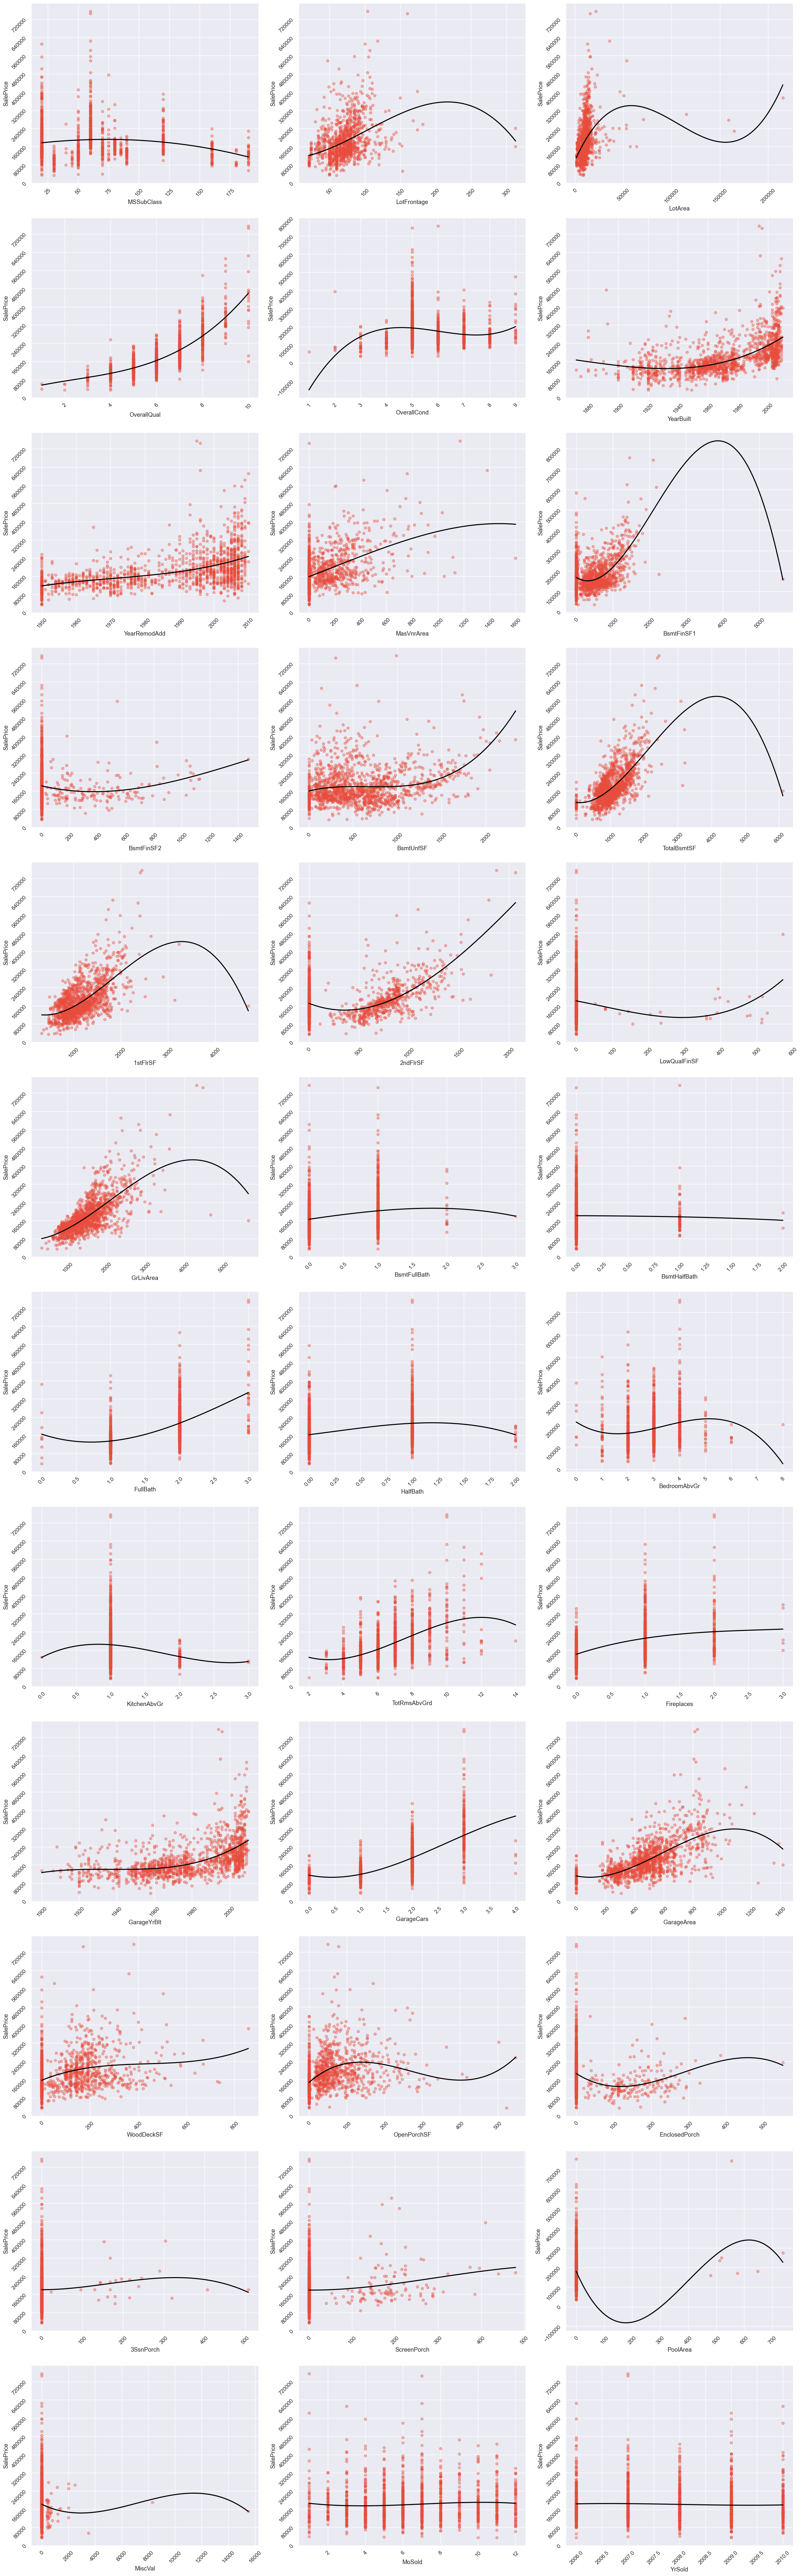

In [25]:
# srt_reg('SalePrice', train)

- Observations
    - OverallQual
        - It's clearly visible that sale price of the house increases with overall quality. This confirms the correlation in first table we did at the beginning. (Pearson corr was 0.8)
    - OverallCondition
        - Looks like overall condition is left skewed where most of the houses are around 5/10 condition. But it doesn't effect the price like quality indicator... perhaps the rating was not of high quality
    - YearBuilt
        - Again new buildings are generally expensive than the old ones.
    - Basement
        - General table shows bigger basements are increasing the price but I see some outliers there...
    - GrLivArea
        - This feature is pretty linear but we can spot two outliers effecting this trend. There are some huge area houses with pretty cheap prices, there might be some reason behind it but we better drop them.
    - SaleDates
        - They seem pretty unimportant on sale prices, maybe we can drop them? maybe only contains macro economic trends...

- If the earlier portion of the polynomial trendline show a clear linear relationship, and the later portion doesn't (curved deeply down), may due to outliers, needs to drop or clip outliers.

### Dropping Outliers

Dropping outliers, mostly based on manual observations, for dynamic approach, could try `isolation forests`

In [27]:
# Dropping outliers after detecting them by eye.

features = features.join(y)
features = features.drop(features[(features['OverallQual'] < 5) & (features['SalePrice'] > 200000)].index)
features = features.drop(features[(features['GrLivArea'] > 4000) & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['GarageArea'] > 1200) & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['TotalBsmtSF'] > 3000) & (features['SalePrice'] > 320000)].index)
features = features.drop(features[(features['1stFlrSF'] < 3000) & (features['SalePrice'] > 600000)].index)
features = features.drop(features[(features['1stFlrSF'] > 3000) & (features['SalePrice'] < 200000)].index)

y = features['SalePrice']
y.dropna(inplace=True)
features.drop(columns='SalePrice', inplace=True)

### Creating New Features

- Three types of information that are shown to be highly correlated with target shown by the correlation heatmap
    - Area
    - Quality
    - Amenity
- We can create new features around these 3 types

In [28]:
# Creating new features  based on previous observations. There might be some highly correlated features now. You cab drop them if you want to...
features['TotalSF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] + features['1stFlrSF'] + features['2ndFlrSF'])
features['TotalBathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) + features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] + features['EnclosedPorch'] + features['ScreenPorch'] + features['WoodDeckSF'])
features['YearBlRm'] = (features['YearBuilt'] + features['YearRemodAdd'])

# Merging quality and conditions.
features['TotalExtQual'] = (features['ExterQual'] + features['ExterCond'])
features['TotalBsmQual'] = (features['BsmtQual'] + features['BsmtCond'] + features['BsmtFinType1'] + features['BsmtFinType2'])
features['TotalGrgQual'] = (features['GarageQual'] + features['GarageCond'])
features['TotalQual'] = features['OverallQual'] + features['TotalExtQual'] + features['TotalBsmQual'] + features['TotalGrgQual'] + features['KitchenQual'] + features['HeatingQC']

# Creating new features by using new quality indicators.
features['QualGr'] = features['TotalQual'] * features['GrLivArea']
features['QualBsm'] = features['TotalBsmQual'] * (features['BsmtFinSF1'] + features['BsmtFinSF2'])
features['QualPorch'] = features['TotalExtQual'] * features['TotalPorchSF']
features['QualExt'] = features['TotalExtQual'] * features['MasVnrArea']
features['QualGrg'] = features['TotalGrgQual'] * features['GarageArea']
features['QlLivArea'] = (features['GrLivArea'] - features['LowQualFinSF']) * (features['TotalQual'])
features['QualSFNg'] = features['QualGr'] * features['Neighborhood']

In [29]:
# Observing the effects of newly created features on sale price.

def srt_reg(feature):
    merged = features.join(y)
    fig, axes = plt.subplots(5, 3, figsize=(25, 40))
    axes = axes.flatten()

    new_features = [
        'TotalSF', 'TotalBathrooms', 'TotalPorchSF', 'YearBlRm',
        'TotalExtQual', 'TotalBsmQual', 'TotalGrgQual', 'TotalQual', 'QualGr',
        'QualBsm', 'QualPorch', 'QualExt', 'QualGrg', 'QlLivArea', 'QualSFNg'
    ]

    for i, j in zip(new_features, axes):

        sns.regplot(x=i,
                    y=feature,
                    data=merged,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

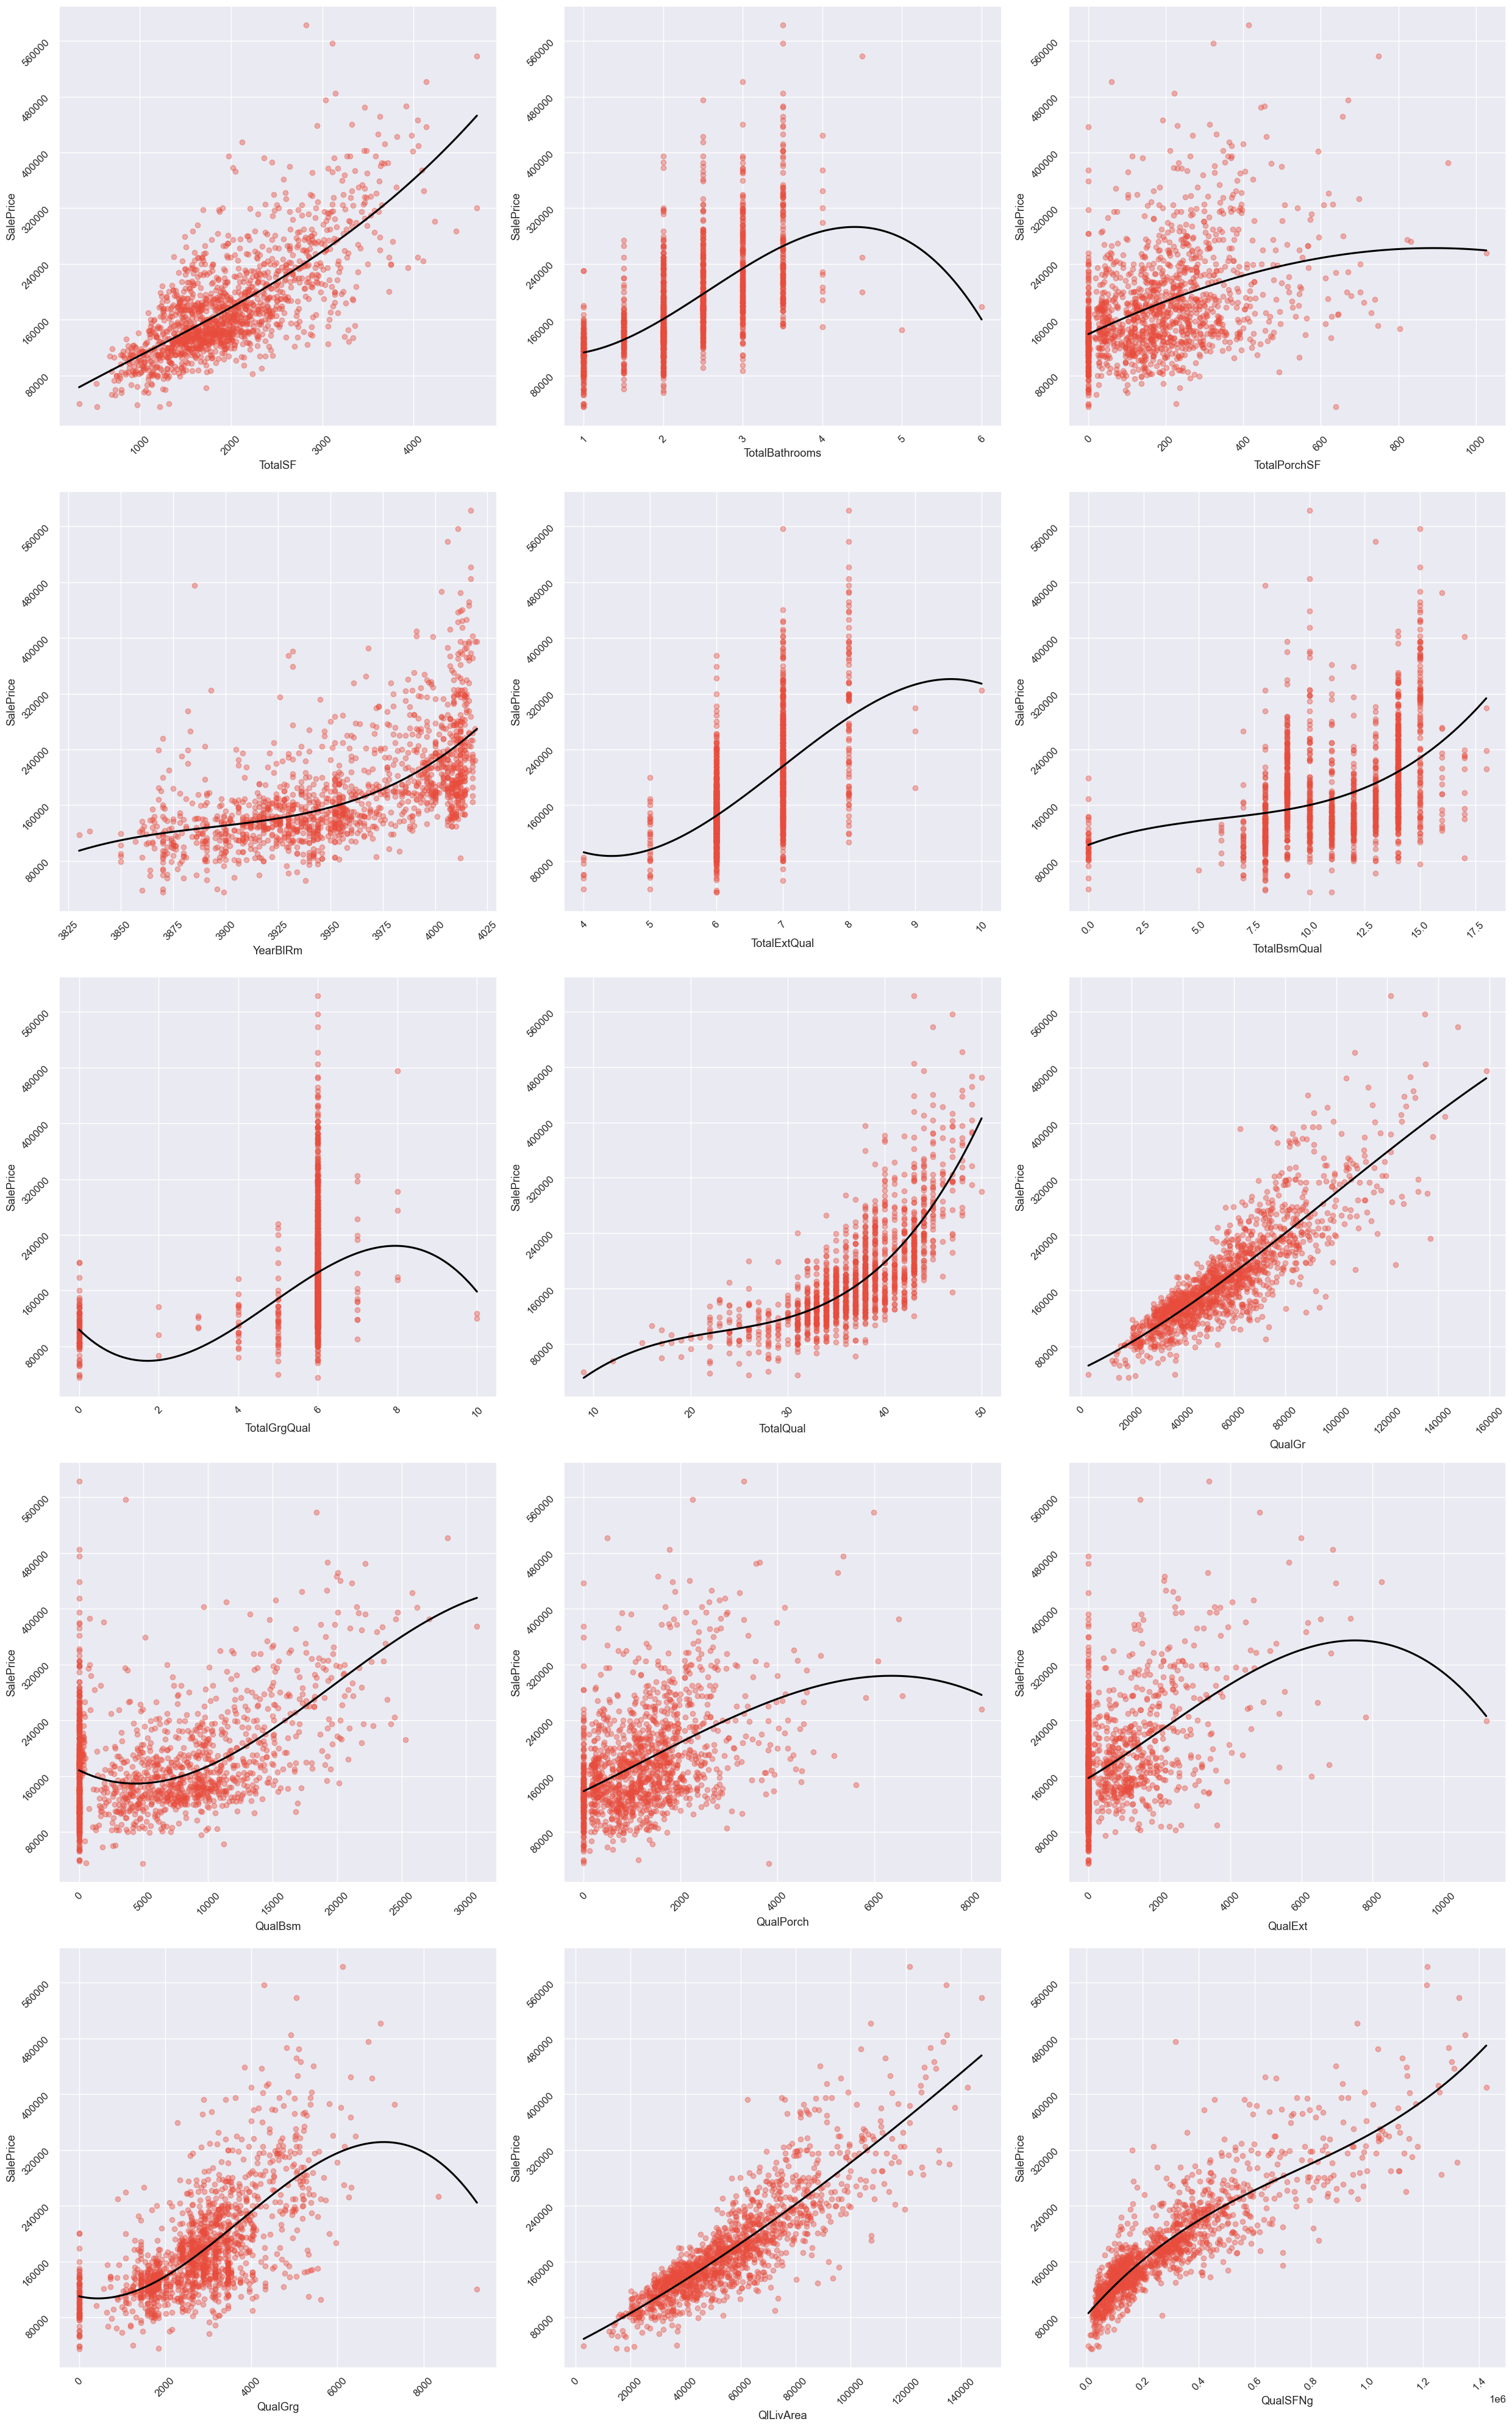

In [30]:
# visuals of new features
srt_reg('SalePrice')

TODO: Remove additional outliers that doesn't conform to linear trends in the data

In [31]:
# Creating some more simple features.

features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['HasGarage'] = features['QualGrg'].apply(lambda x: 1 if x > 0 else 0)
features['HasBsmt'] = features['QualBsm'].apply(lambda x: 1 if x > 0 else 0)
features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
features['HasPorch'] = features['QualPorch'].apply(lambda x: 1 if x > 0 else 0)

### Normalization

In [32]:
# Numerical features we worked on which seems highly skewed but we filter again anyways...

skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal'
]

In [54]:
# Step 1: Select only numeric features
numeric_features = features.select_dtypes(include=[np.number])

# Step 2: Identify skewed numeric features
skew_features = numeric_features.apply(lambda x: skew(x.dropna()))
skew_features = np.abs(skew_features.sort_values(ascending=False))

# Step 3: Select highly skewed features
high_skew = skew_features[skew_features > 0.3]
skew_index = high_skew.index

# Step 4: Apply PowerTransformer with Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson', standardize=True)  # Handles both positive and negative values
features[skew_index] = pt.fit_transform(features[skew_index])

print("PowerTransformer applied successfully to skewed features.")

PowerTransformer applied successfully to skewed features.


In [55]:
# Subjectively choosing these features to drop:

to_drop = [
    'Utilities',
    'PoolQC',
    'YrSold',
    'MoSold',
    'ExterQual',
    'BsmtQual',
    'GarageQual',
    'KitchenQual',
    'HeatingQC',
]

# Dropping features.

features.drop(columns=to_drop, inplace=True)

### One-hot encode

In [56]:
# Getting dummy variables for categorical data.
features = pd.get_dummies(data=features)

## Final Check before Modeling

In [58]:
print(f'Number of missing values: {features.isna().sum().sum()}')

Number of missing values: 0


In [59]:
features.shape

(2908, 226)

#### Prepare Train/Test

In [60]:
# Separating train and test set.

train = features.iloc[:len(y), :]     # get the len(y) sized first portion of train
test = features.iloc[len(train):, :]  # the rest is test

<Axes: >

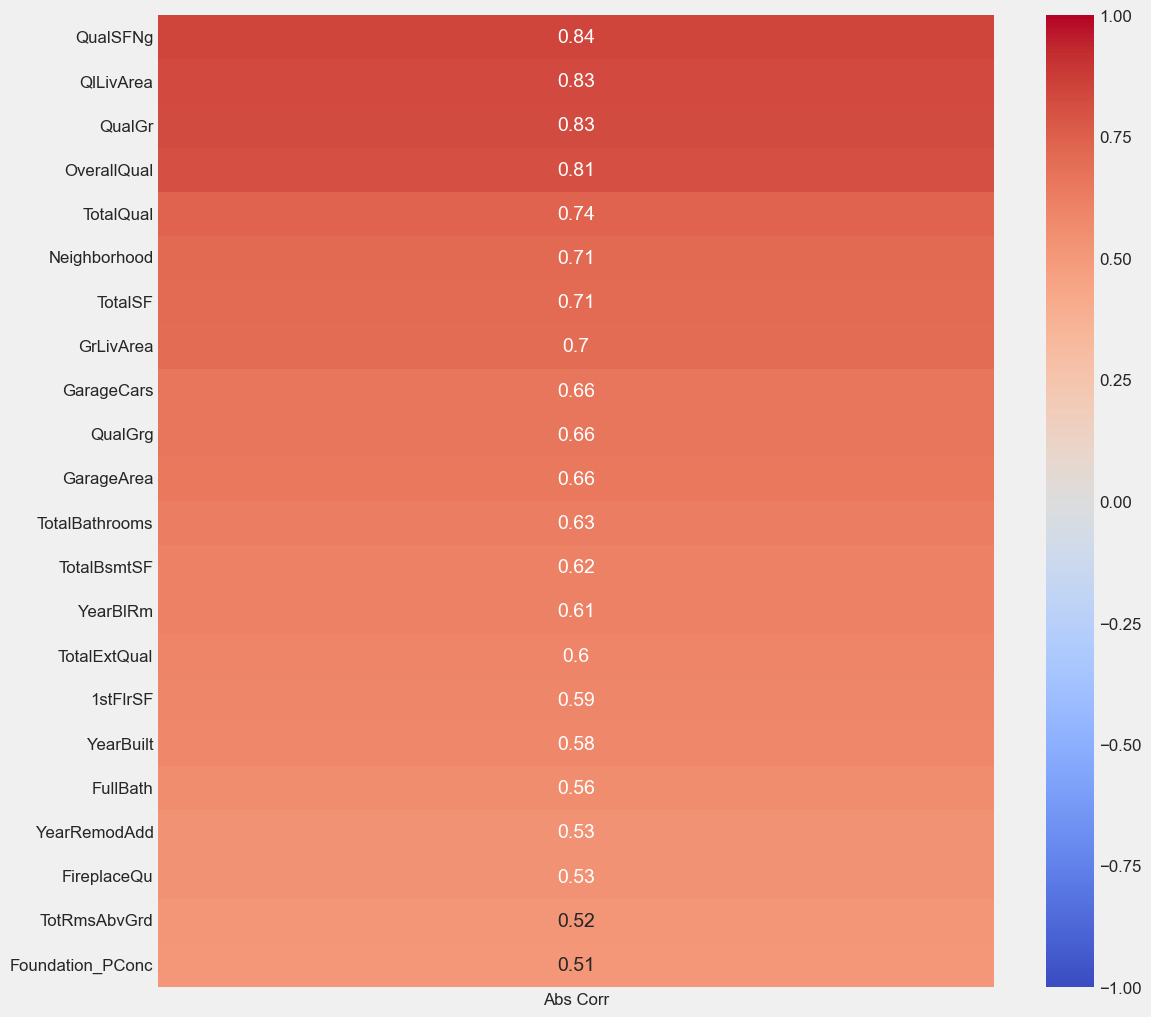

In [61]:
# check correlations vs. target again
correlations = train.join(y).corrwith(train.join(y)['SalePrice']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.5], cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax)

In [72]:
def plot_dist3(df, feature, title):
    
    # Creating a customized chart. and giving in figsize and everything.
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    # creating a grid of 3 cols and 3 rows.
    
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    
    ax1 = fig.add_subplot(grid[0, :2])
    
    # Set the title.
    
    ax1.set_title('Histogram')
    
    # plot the histogram.
    
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # customizing the QQ_plot.
    
    ax2 = fig.add_subplot(grid[1, :2])
    
    # Set the title.
    
    ax2.set_title('Probability Plot')
    
    # Plotting the QQ_Plot.
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Customizing the Box Plot:
    
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    
    ax3.set_title('Box Plot')
    
    # Plotting the box plot.
    
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{title}', fontsize=24)

In [73]:
plot_dist3(train.join(y), 'SalePrice', 'Sale Price Before Log Transformation')

In [74]:
# Setting model data.

X = train
X_test = test
y = np.log1p(y) # log transform SalePrice

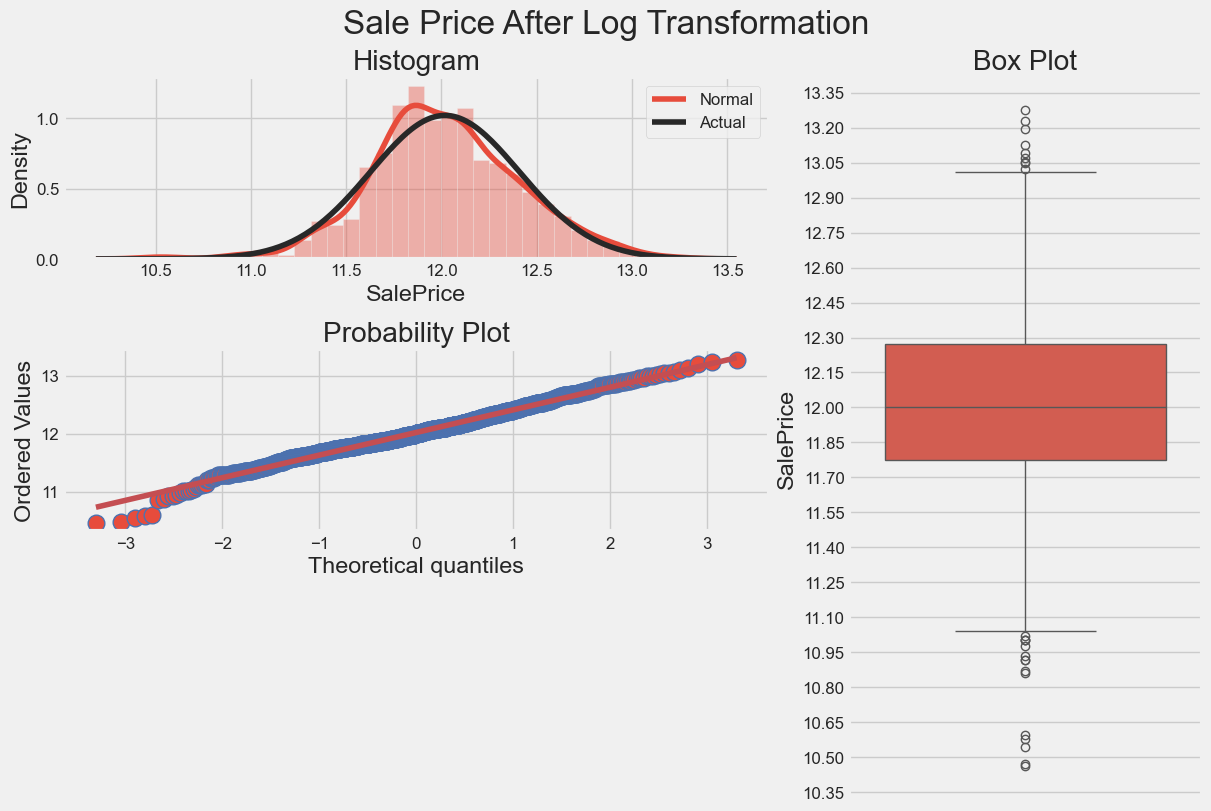

In [75]:
plot_dist3(train.join(y), 'SalePrice', 'Sale Price After Log Transformation')

## Modeling

In [76]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

In [78]:
kf = KFold(10, shuffle=True, random_state=1)

In [90]:
# Some tuned parameters for ridge, lasso and elasticnet.

alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# ridge_cv
ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

# lasso_cv:
lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=5000, alphas=alphas2, random_state=42, cv=kf
))

# elasticnet_cv:
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=5000,
                 alphas=e_alphas,
                 cv=kf,
                 random_state=42,
                 l1_ratio=e_l1ratio
))

# svr:
svr = make_pipeline(RobustScaler(), SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))

# gradientboosting:
gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

# lightgbm:
lightgbm = LGBMRegressor(objective='regression',
                         n_estimators=3500,
                         num_leaves=5,
                         learning_rate=0.00721,
                         max_bin=163,
                         bagging_fraction=0.35711,
                         n_jobs=-1,
                         bagging_seed=42,
                         feature_fraction_seed=42,
                         bagging_freq=7,
                         feature_fraction=0.1294,
                         min_data_in_leaf=8)

# xgboost:
xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,
)


# hist gradient boosting regressor:
hgrd= HistGradientBoostingRegressor(loss= 'squared_error',
    max_depth= 2,
    min_samples_leaf= 40,
    max_leaf_nodes= 29,
    learning_rate= 0.15,
    max_iter= 225,
    random_state=42)

# tweedie regressor:
tweed = make_pipeline(RobustScaler(),TweedieRegressor(alpha=0.005))


# stacking regressor:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm,hgrd, tweed),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [91]:
def model_check(X, y, estimators, cv):
    
    ''' A function for testing multiple estimators.'''
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results['train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'],
                            ascending=True,
                            inplace=True)

    return model_table

In [92]:
# Setting list of estimators and labels for them:

estimators = [ridge, lasso, elasticnet, gbr, xgboost, lightgbm, svr, hgrd, tweed]
labels = [
    'Ridge', 'Lasso', 'Elasticnet', 'GradientBoostingRegressor',
    'XGBRegressor', 'LGBMRegressor', 'SVR', 'HistGradientBoostingRegressor','TweedieRegressor'
]

### Fit Module

In [93]:
raw_models = model_check(X, y, estimators, kf)
display(raw_models.style.background_gradient(cmap='summer_r'))

### Stacking & Blending